In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/camvid.zip"

Archive:  /content/drive/MyDrive/camvid.zip
  inflating: CamVid/class_dict.csv   
  inflating: CamVid/test/0001TP_006690.png  
  inflating: CamVid/test/0001TP_006720.png  
  inflating: CamVid/test/0001TP_006750.png  
  inflating: CamVid/test/0001TP_006780.png  
  inflating: CamVid/test/0001TP_006810.png  
  inflating: CamVid/test/0001TP_006840.png  
  inflating: CamVid/test/0001TP_006870.png  
  inflating: CamVid/test/0001TP_006900.png  
  inflating: CamVid/test/0001TP_006930.png  
  inflating: CamVid/test/0001TP_006960.png  
  inflating: CamVid/test/0001TP_006990.png  
  inflating: CamVid/test/0001TP_007020.png  
  inflating: CamVid/test/0001TP_007050.png  
  inflating: CamVid/test/0001TP_007080.png  
  inflating: CamVid/test/0001TP_007110.png  
  inflating: CamVid/test/0001TP_007140.png  
  inflating: CamVid/test/0001TP_007170.png  
  inflating: CamVid/test/0001TP_007200.png  
  inflating: CamVid/test/0001TP_007230.png  
  inflating: CamVid/test/0001TP_007260.png  
  inflating: CamVi

In [3]:
view = 0
batch_sz = 4
epochs = 1
steps_per_epoch = 1000
validation_steps = 100

In [4]:
import os

In [5]:
import pandas as pd
classes = pd.read_csv("/content/CamVid/class_dict.csv", index_col =0)

In [6]:
classes

,r,g,b
name,,,
Animal,64,128,64
Archway,192,0,128
Bicyclist,0,128,192
Bridge,0,128,64
Building,128,0,0
Car,64,0,128
CartLuggagePram,64,0,192
Child,192,128,64
Column_Pole,192,192,128


In [7]:
n_classes = len(classes)
n_classes

32

In [8]:
cls2rgb = {cl:list(classes.loc[cl, :]) for cl in classes.index}

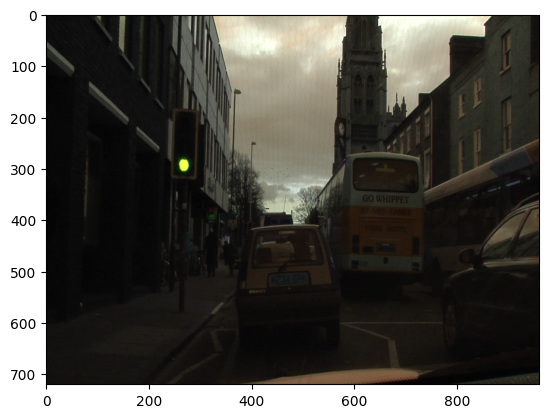

In [9]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import  cv2_imshow

img = cv2.imread("/content/CamVid/test/0001TP_006690.png")
plt.imshow(img)

In [10]:
import numpy as np
mask = cv2.imread("/content/CamVid/test_labels/0001TP_006690_L.png")
mask = cv2.cvtColor((mask).astype(np.uint8), cv2.COLOR_BGR2RGB)

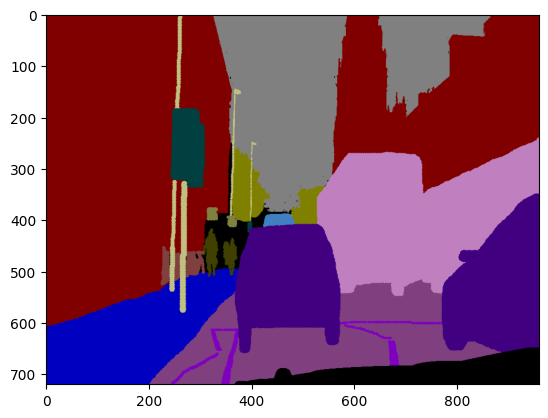

In [11]:
plt.imshow(mask)

In [12]:
mask.shape

(720, 960, 3)

In [13]:
def adjust_mask(mask, flat=False):

    semantic_map = []
    for colour in list(cls2rgb.values()):
        equality = np.equal(mask, colour)# 256x256x3 with True or False
        class_map = np.all(equality, axis = -1)# 256x256 If all True, then True, else False
        semantic_map.append(class_map)# List of 256x256 arrays, map of True for a given found color at the pixel, and False otherwise.
    semantic_map = np.stack(semantic_map, axis=-1)# 256x256x32 True only at the found color, and all False otherwise.
    if flat:
      semantic_map = np.reshape(semantic_map, (-1,256*256))

    return np.float32(semantic_map)# convert to numbers

In [14]:
new_mask = adjust_mask(mask)

In [15]:
new_mask.shape

(720, 960, 32)

In [16]:
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}

In [17]:
def map_class_to_rgb(p):

  return idx2rgb[p[0]]

rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(new_mask, axis=-1), -1))

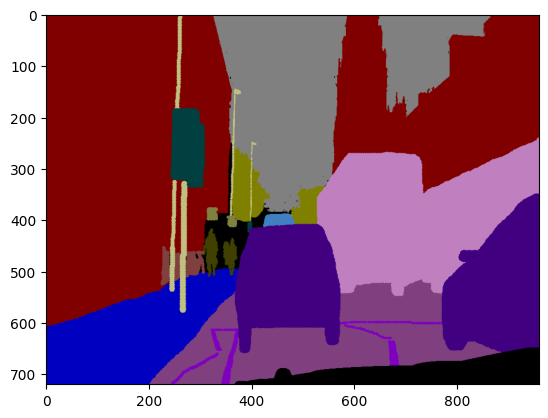

In [18]:
plt.imshow(rgb_mask)

In [19]:
import numpy as np
import os
#import skimage.io as io
#import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

In [20]:
def unet(n_classes, pretrained_weights = None,input_size = (256,256,3), flat=False, ohe=True):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv10 = Conv2D(n_classes, (1,1), activation = 'softmax')(conv9)
    conv10 = Conv2D(n_classes, (1,1), padding='same')(conv9)
    if flat:
      output_layer = Reshape((256*256,n_classes))(conv10)
    else:
      output_layer = conv10
    output_layer = Activation('softmax')(output_layer)


    model = Model( inputs,output_layer)

    if ohe:
      model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    else:
      model.compile(optimizer = Adam(lr = 1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model



In [21]:
model = unet(n_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [24]:
from keras.preprocessing.image import load_img
data_path="/content/CamVid"
def load_CAMVID(data_type='train', enc='ohe', shape='normal'):
  img_path = str(data_path) + '/' + data_type + '/'
  labels_path = str(data_path) + '/' + data_type + '_labels/'
  # without adding target_size=(256,256) in load_img we get Out of mem: 421x960x720x32x4bytes is around 34GB!
  x = np.array([np.array(load_img(str(img_path) + file, target_size=(256,256)))*1./255 for file in sorted(os.listdir(img_path))])
  if(enc=='ohe'):

    y = np.array([adjust_mask(np.array(load_img(str(labels_path) + file, target_size=(256,256)))) for file in sorted(os.listdir(labels_path))])
  elif(enc=='sparse_cat'):
    y = np.array([adjust_mask(np.array(load_img(str(labels_path) + file, target_size=(256,256)))) for file in sorted(os.listdir(labels_path))])
  if(shape == 'flat'):
    y = np.reshape(y.shape[0], y.shape[1]*y.shape[2])
    y = np.expand_dims(y, axis=-1)
  return x, y


In [22]:
x_train, y_train = load_CAMVID(data_type='train')
x_val, y_val = load_CAMVID(data_type='val')

In [23]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(369, 256, 256, 3)
(369, 256, 256, 32)
(100, 256, 256, 3)
(100, 256, 256, 32)


In [24]:
x_train=x_train[:300,:]
y_train=y_train[:300,:]
x_val=x_val[:50,:]
y_val=y_val[:50,:]

In [25]:
model_checkpoint = ModelCheckpoint('unet_camvid.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
model.fit(x=x_train,
              y=y_train,
              validation_data=(x_val, y_val),
              batch_size=batch_sz,# 32 gives OOM sometimes
              epochs=epochs,
              callbacks=[model_checkpoint])

75/75 [==============================] - ETA: 0s - loss: 3.0167 - accuracy: 0.3809
Epoch 1: val_loss improved from inf to 1.57832, saving model to unet_camvid.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 61s 443ms/step - loss: 3.0167 - accuracy: 0.3809 - val_loss: 1.5783 - val_accuracy: 0.5734


In [22]:
model.load_weights("/content/unet_camvid.hdf5")

In [29]:
def visualize_seg(img, gt_mask, shape='normal', gt_mode='sparse'):
  plt.figure(1)

  # Img
  plt.subplot(311)
  plt.imshow(img)

  # Predict
  pred_mask = model.predict(np.expand_dims(img, 0))
  pred_mask = np.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[0]
  if shape=='flat':
    pred_mask = np.reshape(pred_mask, (256,256)) # Reshape only if you use the flat model. O.w. you dont need

  rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(pred_mask, -1))

  # Prediction
  plt.subplot(312)
  plt.imshow(rgb_mask)

  # GT mask
  if gt_mode == 'ohe':
    gt_img_ohe = np.argmax(gt_mask, axis=-1)
    gt_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(gt_img_ohe, -1))

  plt.subplot(313)
  plt.imshow((gt_mask).astype(np.uint8))

In [ ]:
x_test, y_test = load_CAMVID(data_type='test')

1/1 [==============================] - 3s 3s/step


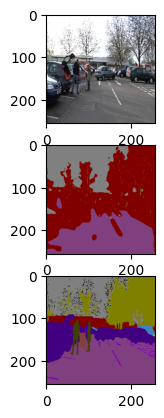

In [31]:
visualize_seg(x_test[100], y_test[100], gt_mode='ohe')

In [41]:
res=[]
for i in x_test:
  pred_mask = model.predict(np.expand_dims(i, 0))
  pred_mask = np.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[0]
  rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(pred_mask, -1))
  res.append(rgb_mask)

1/1 [==============================] - 0s 29ms/step


In [51]:
res=np.array(res)

In [52]:
res

array([[[[128,   0,   0],
         [128,   0,   0],
         [128,   0,   0],
         ...,
         [128,   0,   0],
         [128,   0,   0],
         [128,   0,   0]],

        [[128,   0,   0],
         [128,   0,   0],
         [128,   0,   0],
         ...,
         [128,   0,   0],
         [128,   0,   0],
         [128,   0,   0]],

        [[128,   0,   0],
         [128,   0,   0],
         [128,   0,   0],
         ...,
         [128,   0,   0],
         [128,   0,   0],
         [128,   0,   0]],

        ...,

        [[128,  64, 128],
         [128,  64, 128],
         [128,  64, 128],
         ...,
         [128,  64, 128],
         [128,  64, 128],
         [128,  64, 128]],

        [[128,  64, 128],
         [128,  64, 128],
         [128,  64, 128],
         ...,
         [128,  64, 128],
         [128,  64, 128],
         [128,  64, 128]],

        [[128,  64, 128],
         [128,  64, 128],
         [128,  64, 128],
         ...,
         [128,  64, 128],
        

In [36]:
testing=[]
for i in y_test:
  gt_img_ohe = np.argmax(i, axis=-1)
  i = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(gt_img_ohe, -1))
  testing.append(i)

In [53]:
testing=np.array(testing)

In [56]:
res.shape

(232, 256, 256, 3)

In [57]:
testing.shape

(232, 256, 256, 3)

In [66]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(testing.flatten(), res.flatten())

In [67]:
accuracy

0.7243818743475552